In [1]:
import numpy as np
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import confusion_matrix
from datasets import DatasetDict
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [2]:
def prepare_input_data() :

    raw_dataset = load_dataset(
    'json',
    data_files = {
        "train" : './json/train_jsonl.jsonl',
        "test" : './json/test_jsonl.jsonl'
}
    )
   
    raw_dataset = raw_dataset.class_encode_column('label')

    all_data = DatasetDict({
        "train" : raw_dataset["train"],
        # "valid" : splits['test'],
        'test' : raw_dataset['test']})


    return all_data

In [3]:
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
max_len = 256

def tokenize_fn(batch):
    return tokenizer(
        batch["text"],            # 여기에 'text' 컬럼
        truncation=True,
        padding="max_length",
        max_length=max_len,
    )

In [4]:
def mapping() :
    all_data = prepare_input_data()
    tokenized = all_data.map(tokenize_fn, batched=True)

    # label 컬럼 이름을 labels로 맞춰주기 (Trainer가 labels를 찾음)
    tokenized = tokenized.rename_column('label', 'labels')
    
    
    # 원래 text 컬럼은 이제 필요 없음 (안 지우면 충돌 날 수 있음)
    tokenized = tokenized.remove_columns(["text"])
    
    # HuggingFace가 내부적으로 쓰는 형식 지정
    tokenized.set_format(type="torch")

    train = tokenized['train']
    # valid = tokenized['valid']
    test = tokenized['test']

    return train, test

In [5]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average= 'micro'),
        "precision": precision_score(labels, preds, average='micro',zero_division=0),
        "recall": recall_score(labels, preds, average='micro',zero_division=0),
    }

# 교차검증을 통해 fold별 평균, 표준편차구하기

In [6]:
def run_kfold_cv( ) :
    
    train_set, test_set = mapping() 
    labels = np.array(train_set["labels"])
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_results = []


    for fold, (tr_idx, val_idx) in enumerate(skf.split(np.zeros(len(labels)), labels), 1):
        print(f"Fold {fold}")

        model = AutoModelForSequenceClassification.from_pretrained(
            "klue/bert-base",
            num_labels=4,
        )
        training_args = TrainingArguments(
        output_dir="./klue-bert-mental-v2",   # 새 폴더 쓰는 게 깔끔
        num_train_epochs=10,
        eval_strategy="epoch",
        save_strategy="epoch",
        logging_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="f1")
    
        tr_ds = train_set.select(tr_idx.tolist())
        val_ds = train_set.select(val_idx.tolist())
    
        
        
        trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tr_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

        trainer.train()
        metrics = trainer.evaluate(val_ds)
        cv_results.append(metrics)

    return cv_results


def print_mean_std() :
   
    cv_result = run_kfold_cv()

    metrics = {
        "loss": "eval_loss",
        "accuracy": "eval_accuracy",
        "f1": "eval_f1",
        "precision": "eval_precision",
        "recall": "eval_recall",
    }

    print("===== 5-fold CV Results (mean ± std) =====")
    for name, key in metrics.items():
        values = np.array([r[key] for r in cv_result], dtype=float)
        mean = values.mean()
        std = values.std(ddof=1)   # sample std (권장)

        print(f"{name:<9s}: {mean:.3f} ± {std:.3f}")

# 최종 결과 출력을 위한 과정

In [6]:
def apply_model() :


    train_set, test_set = mapping()
    
    model = AutoModelForSequenceClassification.from_pretrained(
        "klue/bert-base",
        num_labels=4,)

    training_args = TrainingArguments(
    output_dir="./klue-bert-mental-final",   # 새 폴더 쓰는 게 깔끔
    num_train_epochs=3,
    eval_strategy="no",
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    weight_decay=0.01,
    load_best_model_at_end=False,
    metric_for_best_model="f1",
    # report_to = 'tensorboard'
)

    
    trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset = train_set,
    tokenizer=tokenizer,           
    compute_metrics=compute_metrics,
)

    trainer.train()

  
    train_metrics  = trainer.evaluate(train_set, metric_key_prefix="train")
    test_metrics = trainer.evaluate(test_set, metric_key_prefix='test')  
    

    pred_out = trainer.predict(test_set)
    y_pred = np.argmax(pred_out.predictions, axis=1)
    y_true = pred_out.label_ids

    cm = confusion_matrix(y_true, y_pred, labels = list(range(4)))

        # 7) 리포트용 출력(소수 3자리)
    print("===== FINAL REPORT (Train full -> Test once) =====")
    for k, v in train_metrics.items():
        if isinstance(v, (float, int)):
            print(f"{k:20s}: {v:.3f}")
    print("-" * 60)
    for k, v in test_metrics.items():
        if isinstance(v, (float, int)):
            print(f"{k:20s}: {v:.3f}")

    print("-" * 60)
    print("Confusion Matrix (Test)")
    print(cm)
    print("===================================================")

    log_history = trainer.state.log_history
    return {
        "trainer": trainer,
        "train_metrics": train_metrics,
        "test_metrics": test_metrics,
        "confusion_matrix": cm,
        "y_true": y_true,
        "y_pred": y_pred,
        "log_history" : log_history
    }

# 시각화

In [14]:

def visualize_result_report () :
    result = apply_model()
    
    final_true = result['y_true'] 
    final_pred = result['y_pred']
    logs = result['log_history']


    print(classification_report(final_true, final_pred, digits=3))

     # --- parse logs (single pass) ---
    epochs = []
    train_losses = []
    test_loss = None
    test_epoch = None

    for x in logs:
        epoch = x.get("epoch")

        if epoch is not None and "loss" in x:
            epochs.append(epoch)
            train_losses.append(x["loss"])

        if "test_loss" in x:
            test_loss = x["test_loss"]
            test_epoch = epoch

    
    label_names = ["depression", "addiction", "anxiety", "normal"] 

    # --- plot: loss + confusion matrix ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # (1) Loss curve
    axes[0].plot(epochs, train_losses, marker="o", label="Train Loss")
    if test_loss is not None:
        # test_epoch가 None이면 마지막 epoch에 찍기
        x_te = test_epoch if test_epoch is not None else (max(epochs) if epochs else 0)
        axes[0].scatter(x_te, test_loss, s=80, color='red', label=f"Test Loss = {test_loss:.3f}")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Training Loss (with Final Test Loss)")
    axes[0].grid(True)
    axes[0].legend()


    # (2) Confusion matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        final_true, final_pred,
        normalize="true",
        cmap="Blues",
        ax=axes[1] ,
        display_labels=label_names                # ✅ 같은 figure의 오른쪽 축에 그리기
    )

    
    for i in range(4):
        axes[1].axhline(i - 0.5, color="black", linewidth=1.5)
        axes[1].axvline(i - 0.5, color="black", linewidth=1.5)
    
    axes[1].set_title("Confusion Matrix (Row-normalized)")

    plt.tight_layout()
    plt.show()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\user\AppData\Local\Temp\ipykernel_13476\2490380568.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
11,1.408300
22,1.251200
33,1.165900


===== FINAL REPORT (Train full -> Test once) =====
train_loss          : 1.092
train_accuracy      : 0.657
train_f1            : 0.657
train_precision     : 0.657
train_recall        : 0.657
train_runtime       : 1.415
train_samples_per_second: 119.415
train_steps_per_second: 4.240
epoch               : 3.000
------------------------------------------------------------
test_loss           : 1.237
test_accuracy       : 0.465
test_f1             : 0.465
test_precision      : 0.465
test_recall         : 0.465
test_runtime        : 0.315
test_samples_per_second: 136.686
test_steps_per_second: 6.357
epoch               : 3.000
------------------------------------------------------------
Confusion Matrix (Test)
[[10  2  1  0]
 [ 1  5  5  0]
 [ 2  6  5  0]
 [ 2  3  1  0]]


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

              precision    recall  f1-score   support

           0      0.667     0.769     0.714        13
           1      0.312     0.455     0.370        11
           2      0.417     0.385     0.400        13
           3      0.000     0.000     0.000         6

    accuracy                          0.465        43
   macro avg      0.349     0.402     0.371        43
weighted avg      0.407     0.465     0.432        43



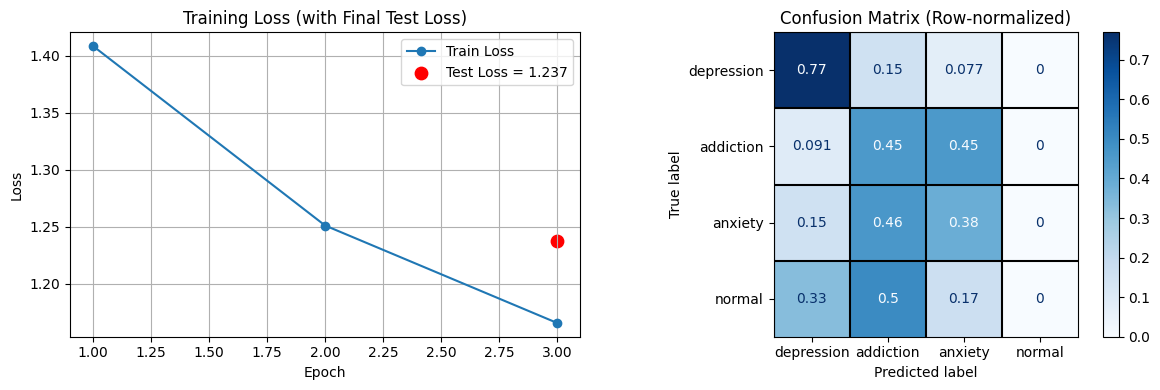

In [15]:
visualize_result_report()